In [ ]:
import pandas as pd
import torch
import random
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from torch.distributions import MultivariateNormal
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import chi2, norm

# Set seeds
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Data preparation
def prepare_data(device, path, n_samples=400, test_size=0.2, recal_size=0.2, batch_size=32, seed=5, bootstrap=False):
    set_seed(seed)
    data = pd.read_excel(path)
    data = data.sample(n=n_samples, replace=bootstrap, random_state=seed)
    X = data.iloc[:, :-2].values
    y = data.iloc[:, -2:].values

    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    recal_split = recal_size / (1 - test_size)
    X_train, X_recal, y_train, y_recal = train_test_split(X_temp, y_temp, test_size=recal_split, random_state=seed)

    X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
    X_recal, y_recal = torch.tensor(X_recal).float(), torch.tensor(y_recal).float()
    X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()

    mean_X, std_X = X_train.mean(0), X_train.std(0)
    mean_y, std_y = y_train.mean(0), y_train.std(0)

    X_train = (X_train - mean_X) / std_X
    X_recal = (X_recal - mean_X) / std_X
    X_test = (X_test - mean_X) / std_X
    y_train = (y_train - mean_y) / std_y
    y_recal = (y_recal - mean_y) / std_y
    y_test = (y_test - mean_y) / std_y

    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    
    return X_train, y_train, train_loader, X_recal, y_recal, X_test, y_test, mean_y, std_y


# Model
class CorrelatedProbabilisticRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.hidden = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )
        self.mean_head = nn.Linear(64, 2)
        self.cov_head = nn.Linear(64, 3)

    def forward(self, x):
        h = self.hidden(x)
        mu = self.mean_head(h)
        cov_params = self.cov_head(h)
        log_std1, log_std2 = cov_params[:, 0], cov_params[:, 1]
        corr = torch.tanh(cov_params[:, 2])
        std1, std2 = torch.exp(log_std1), torch.exp(log_std2)
        covs = []
        for i in range(x.size(0)):
            s1, s2, r = std1[i], std2[i], corr[i]
            cov = torch.tensor([[s1**2, r*s1*s2], [r*s1*s2, s2**2]], device=x.device)
            covs.append(cov)
        cov_stack = torch.stack(covs)
        return mu, cov_stack

# Loss and adversarial
def mvn_nll(y, mu, cov):
    dist = MultivariateNormal(mu, covariance_matrix=cov)
    return -dist.log_prob(y).mean()

def fgsm_attack(model, x, y, epsilon=0.01):
    x_adv = x.detach().clone().requires_grad_(True)
    mu, cov = model(x_adv)
    loss = mvn_nll(y, mu, cov)
    loss.backward()
    return (x + epsilon * torch.sign(x_adv.grad)).detach()

# Train ensemble with logging
def train_ensemble_with_logging(M, train_loader, input_dim, device, epochs=500, epsilon=0.01):
    ensemble, all_losses = [], []
    for _ in range(M):
        model = CorrelatedProbabilisticRegressor(input_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        losses = []
        for _ in range(epochs):
            model.train()
            epoch_loss = 0.0
            for xb, yb in train_loader:
                xb_adv = fgsm_attack(model, xb, yb, epsilon)
                mu, cov = model(xb_adv)
                loss = mvn_nll(yb, mu, cov)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            losses.append(epoch_loss / len(train_loader))
        ensemble.append(model)
        all_losses.append(losses)
    return ensemble, all_losses

# Ensemble prediction
def predict_ensemble(ensemble, x, device):
    mus, covs = [], []
    for model in ensemble:
        model.eval()
        with torch.no_grad():
            mu, cov = model(x)
            mus.append(mu)
            covs.append(cov)
    mus = torch.stack(mus)
    covs = torch.stack(covs)
    mu_mean = mus.mean(0)
    epi_cov = torch.einsum('mni,mnj->nij', mus - mu_mean, mus - mu_mean) / len(ensemble)
    alea_cov = covs.mean(0)
    return mu_mean, alea_cov + epi_cov

# Evaluation and plots
def plot_loss_curves(loss_logs):
    mean_loss_per_epoch = np.mean(loss_logs, axis=0)
    plt.figure(figsize=(10, 5))
    plt.plot(mean_loss_per_epoch, label='Epoch Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_predicted_vs_true_dual(y_train, mu_train, y_test, mu_test, std_y, target_names=["Measured Voltage", "Predicted Voltage"]):
    y_train_np = y_train.cpu().numpy() * std_y.cpu().numpy()
    mu_train_np = mu_train.cpu().numpy() * std_y.cpu().numpy()
    y_test_np = y_test.cpu().numpy() * std_y.cpu().numpy()
    mu_test_np = mu_test.cpu().numpy() * std_y.cpu().numpy()

    for i in range(2):
        plt.figure(figsize=(6, 6))
        plt.scatter(y_train_np[:, i], mu_train_np[:, i], alpha=0.5, label='Train', color='blue')
        plt.scatter(y_test_np[:, i], mu_test_np[:, i], alpha=0.5, label='Test', color='orange')
        plt.plot([min(y_train_np[:, i].min(), y_test_np[:, i].min()),
                  max(y_train_np[:, i].max(), y_test_np[:, i].max())],
                 [min(y_train_np[:, i].min(), y_test_np[:, i].min()),
                  max(y_train_np[:, i].max(), y_test_np[:, i].max())],
                 'k--', label='Ideal')
        plt.xlabel("True Values")
        plt.ylabel("Predicted Mean")
        plt.title(f"Predicted vs. True: {target_names[i]}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def full_evaluation(y_true, mu_pred, cov_pred, std_y, alpha=0.8):
    y_true_np = y_true.cpu().numpy() * std_y.cpu().numpy()
    mu_pred_np = mu_pred.cpu().numpy() * std_y.cpu().numpy()
    cov_np = cov_pred.cpu().numpy()
    cov_np = np.array([c * (std_y.cpu().numpy()[:, None] * std_y.cpu().numpy()) for c in cov_np])
    inv_cov = np.linalg.inv(cov_np)
    errors = y_true_np - mu_pred_np
    distances = np.einsum('ni,nij,nj->n', errors, inv_cov, errors)

    mae = np.mean(np.abs(errors), axis=0)
    rmse = np.sqrt(np.mean(errors**2, axis=0))
    mse = np.mean(errors**2, axis=0)
    r2 = [r2_score(y_true_np[:, i], mu_pred_np[:, i]) for i in range(2)]
    z = norm.ppf(0.5 + alpha / 2)
    diag_std = np.sqrt(np.array([np.diag(c) for c in cov_np]))
    lower = mu_pred_np - z * diag_std
    upper = mu_pred_np + z * diag_std
    picp = np.mean((y_true_np >= lower) & (y_true_np <= upper), axis=0)

    print("Evaluation Metrics:")
    names = ["Measured Voltage", "Predicted Voltage"]
    for i in range(2):
        print(f"\n{names[i]}:")
        print(f"  MAE:   {mae[i]:.4f}")
        print(f"  RMSE:  {rmse[i]:.4f}")
        print(f"  MSE:   {mse[i]:.4f}")
        print(f"  R²:    {r2[i]:.4f}")
        print(f"  PICP (80%): {picp[i]*100:.2f}%")

    return y_true_np, mu_pred_np, distances



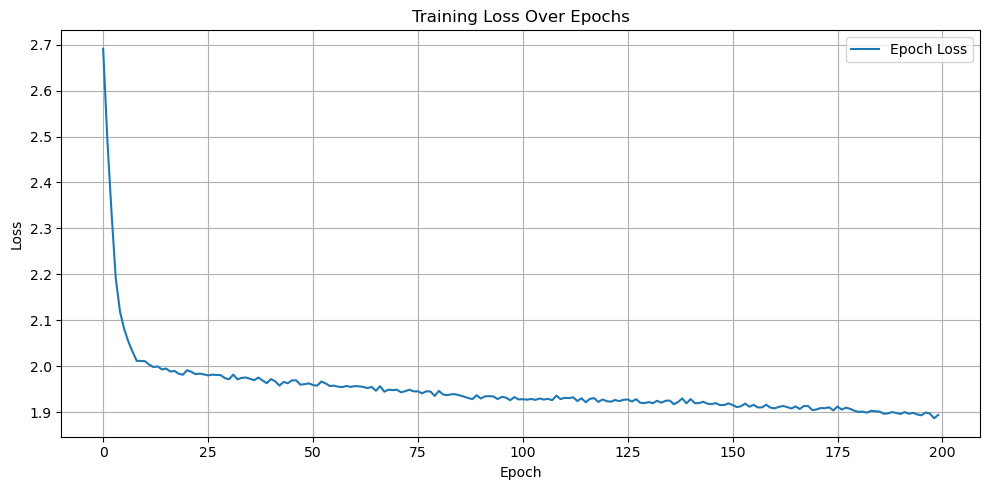

Evaluation Metrics:

Measured Voltage:
  MAE:   0.0055
  RMSE:  0.0069
  MSE:   0.0000
  R²:    0.9990
  PICP (80%): 100.00%

Predicted Voltage:
  MAE:   0.0536
  RMSE:  0.0767
  MSE:   0.0059
  R²:    0.9028
  PICP (80%): 99.58%
Evaluation Metrics:

Measured Voltage:
  MAE:   0.0103
  RMSE:  0.0189
  MSE:   0.0004
  R²:    0.9942
  PICP (80%): 100.00%

Predicted Voltage:
  MAE:   0.1115
  RMSE:  0.1486
  MSE:   0.0221
  R²:    0.7092
  PICP (80%): 98.75%


In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "synthetic_data.xlsx"

# Make sure your prepare_data function returns recalibration set now!
X_train, y_train, train_loader, X_recal, y_recal, X_test, y_test, mean_y, std_y = prepare_data(
    device=device,
    path=file_path,
    n_samples=400,
    test_size=0.2,
    recal_size=0.2,
    batch_size=32,
    seed=42,
    bootstrap=False
)

ensemble, loss_logs = train_ensemble_with_logging(
    M=5,
    train_loader=train_loader,
    input_dim=X_train.shape[1],
    device=device,
    epochs=200,
    epsilon=0.01
)

plot_loss_curves(loss_logs)

mu_train, cov_train = predict_ensemble(ensemble, X_train, device=device)
mu_test, cov_test = predict_ensemble(ensemble, X_test, device=device)

y_true_train_denorm, mu_train_denorm, distances_train = full_evaluation(
    y_true=y_train,
    mu_pred=mu_train,
    cov_pred=cov_train,
    std_y=std_y,
    alpha=0.8
)
y_true_test_denorm, mu_test_denorm, distances_test = full_evaluation(
    y_true=y_test,
    mu_pred=mu_test,
    cov_pred=cov_test,
    std_y=std_y,
    alpha=0.8
)


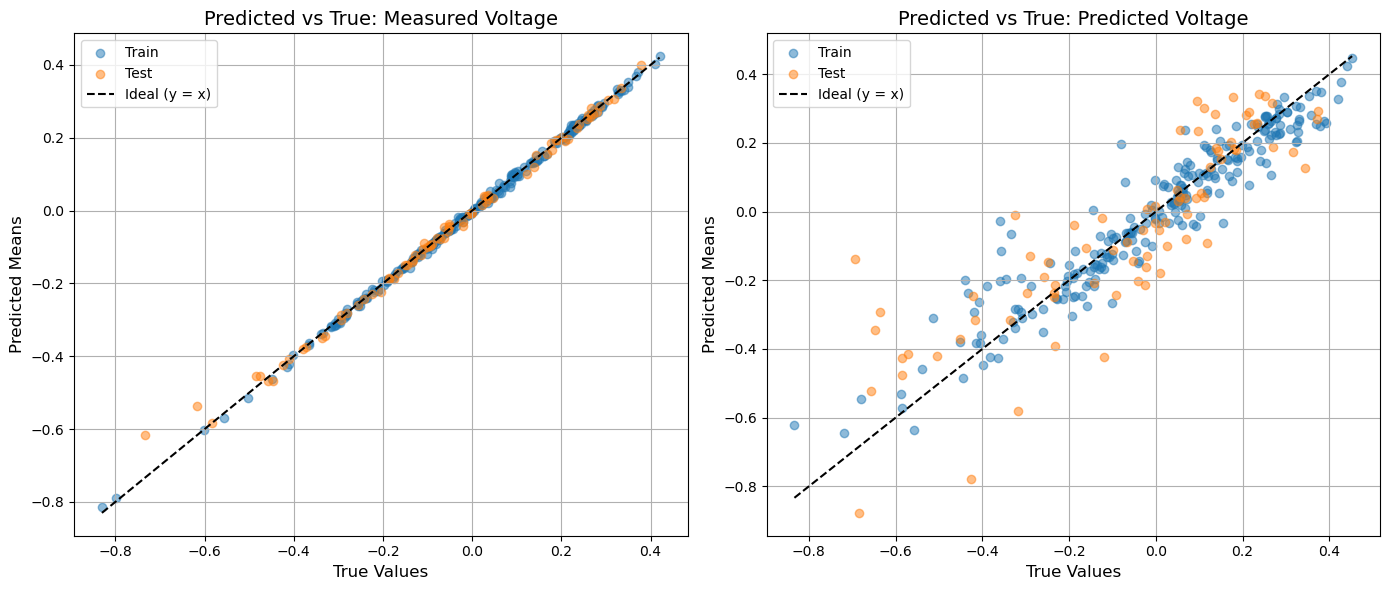

In [58]:
def plot_predicted_vs_true_dual(y_train, mu_train, y_test, mu_test, target_names=["Measured Voltage", "Predicted Voltage"]):
    """
    Plots predicted vs true for both train and test sets.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    for i in range(2):
        ax = axes[i]
        ax.scatter(y_train[:, i], mu_train[:, i], alpha=0.5, label="Train", color='tab:blue')
        ax.scatter(y_test[:, i], mu_test[:, i], alpha=0.5, label="Test", color='tab:orange')

        min_val = min(y_train[:, i].min(), y_test[:, i].min())
        max_val = max(y_train[:, i].max(), y_test[:, i].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', label="Ideal (y = x)")

        ax.set_xlabel("True Values", fontsize=12)
        ax.set_ylabel("Predicted Means", fontsize=12)
        ax.set_title(f"Predicted vs True: {target_names[i]}", fontsize=14)
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

# Try to plot using available variables (if reloaded)
try:
    plot_predicted_vs_true_dual(
        y_train=y_true_train_denorm,
        mu_train=mu_train_denorm,
        y_test=y_true_test_denorm,
        mu_test=mu_test_denorm
    )
except NameError as e:
    print(f"Missing variable: {e}. Please re-run the cell where 'y_true_train_denorm' and related outputs were computed.")
    


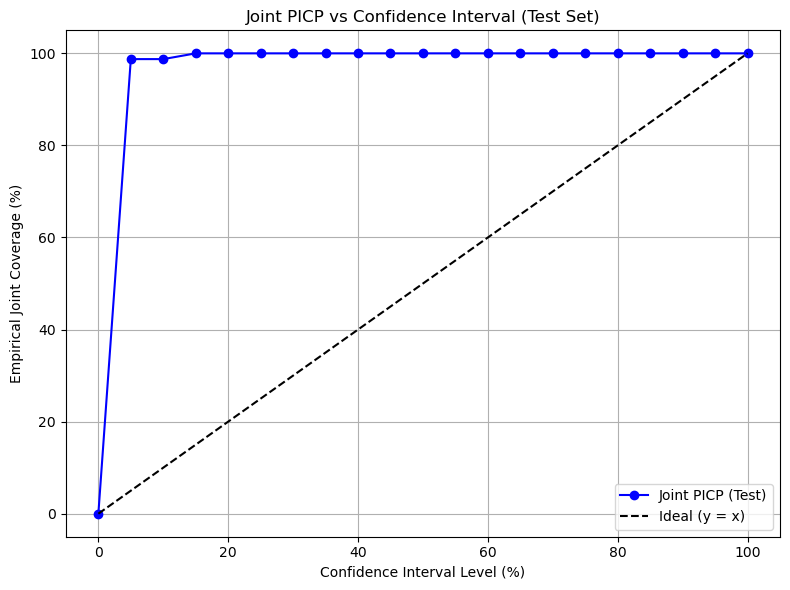

In [55]:
# Re-import necessary libraries after code reset
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# Redefine function to compute joint PICP curve
def compute_joint_picp_curve(y_true_np, mu_pred_np, cov_pred_np, levels=np.linspace(0.0, 1.0, 21)):
    D = y_true_np.shape[1]
    diffs = y_true_np - mu_pred_np
    empirical_coverages = []
    for alpha in levels:
        threshold = chi2.ppf(alpha, df=D) if alpha < 1.0 else np.inf
        mahalanobis_sq = np.array([
            d @ np.linalg.inv(c + 1e-3 * np.eye(D)) @ d
            for d, c in zip(diffs, cov_pred_np)
        ])
        coverage = np.mean(mahalanobis_sq <= threshold)
        empirical_coverages.append(coverage)
    return levels, np.array(empirical_coverages)

# Use existing test data
cov_test_np = cov_test.cpu().numpy()
levels, joint_picp = compute_joint_picp_curve(
    y_true_np=y_true_test_denorm,
    mu_pred_np=mu_test_denorm,
    cov_pred_np=cov_test_np
)

# Plot joint PICP vs confidence interval
plt.figure(figsize=(8, 6))
plt.plot(levels * 100, joint_picp * 100, 'o-', label='Joint PICP (Test)', color='blue')
plt.plot([0, 100], [0, 100], 'k--', label='Ideal (y = x)')
plt.xlabel("Confidence Interval Level (%)")
plt.ylabel("Empirical Joint Coverage (%)")
plt.title("Joint PICP vs Confidence Interval (Test Set)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [75]:
# Compute optimal lambda for standard scaling that minimizes ECE
def find_best_covariance_scale(y_true_np, mu_pred_np, cov_pred_np, level_grid=np.linspace(0.0, 1.0, 21), scale_grid=np.linspace(0.0001, 2.0, 1000)):
    best_ece = float('inf')
    best_lambda = None
    best_curve = None
    for lam in scale_grid:
        scaled_cov = cov_pred_np * lam
        levels, picp = compute_joint_picp_curve(y_true_np, mu_pred_np, scaled_cov, levels=level_grid)
        ece = compute_joint_ece(levels, picp)
        if ece < best_ece:
            best_ece = ece
            best_lambda = lam
            best_curve = (levels, picp)
    return best_lambda, best_ece, best_curve

# Redefine compute_joint_ece to avoid undefined errors
def compute_joint_ece(levels, empirical_coverages):
    return np.mean(np.abs(empirical_coverages - levels))

# Re-compute using test set (if variables are already available)
try:
    best_lambda, best_ece, _ = find_best_covariance_scale(
        y_true_np=y_true_test_denorm,
        mu_pred_np=mu_test_denorm,
        cov_pred_np=cov_test.cpu().numpy()
    )
except NameError as e:
    print(f"Missing variable: {e}. Please re-run the evaluation step to obtain denormalized predictions and ground truth.")
    
best_lambda, best_ece
    


(0.004103803803803804, 0.07738095238095238)

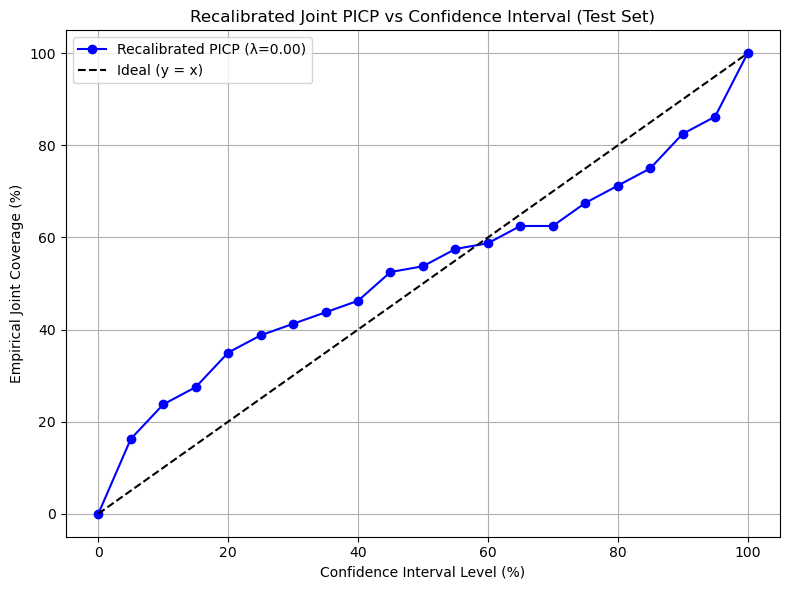

In [76]:
# Assuming you've now re-evaluated the test set and best_lambda was already defined

# We'll define a safe fallback
try:
    # Recompute PICP with scaled covariance using optimal lambda
    scaled_cov_test = cov_test.cpu().numpy() * 0.0041

    # Compute recalibrated joint PICP curve
    levels_scaled, picp_scaled = compute_joint_picp_curve(
        y_true_np=y_true_test_denorm,
        mu_pred_np=mu_test_denorm,
        cov_pred_np=scaled_cov_test
    )

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(levels_scaled * 100, picp_scaled * 100, 'o-', label=f'Recalibrated PICP (λ={best_lambda:.2f})', color='blue')
    plt.plot([0, 100], [0, 100], 'k--', label='Ideal (y = x)')
    plt.xlabel("Confidence Interval Level (%)")
    plt.ylabel("Empirical Joint Coverage (%)")
    plt.title("Recalibrated Joint PICP vs Confidence Interval (Test Set)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
except NameError as e:
    print(f"Missing variable: {e}. Please make sure you've run the evaluation and scaling steps.")
